In [105]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import random
import mitdeeplearning as mdl
from scipy.stats import t


# Training

## REINFORCE algorithm

In [106]:

def create_reinforce_model():
    '''
    Creates a neural network to output the probability of chosing an action given a state
    '''
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=[4]),
        tf.keras.layers.Dense(2, activation='softmax')  #one output for each action
    ])
    return model


In [107]:
def discount_rewards(rewards, gamma=0.95):
    '''
    Function to sum and discount the rewards for each state in the trajectory
    
            Parameters:
                    rewards (list): The rewards aquired at each time step
                    gamma (float): The discount factor
            Returns:
                    Normalised,discounted and summed array of the rewards
     '''
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):

        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)


In [108]:
def normalize(x):
    '''
    Function to normalize an array
    
            Parameters:
                    x (array): Input array to be normalized
            Returns:
                    Normalised array
     '''
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)


In [109]:
def train_reinforce(model, rewards, actions, observations):

    '''
    Function to train the REINFORCE neural network
    
            Parameters:
                    model (tensorflow model): The tensorflow model to be trained
                    rewards (array): The rewards achieved at each time step
                    actions (array): The actions taken at each time step
                    observations (array): The state at each timestep
            Returns:
                    None
     '''



    rewards = discount_rewards(rewards)
    actions = actions.reshape(-1)
    optimizer = tf.keras.optimizers.Adam(1e-3)
    with tf.GradientTape() as tape:
        predictions = model(np.array(observations))
        l = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
        loss = l(actions, predictions)
        loss = tf.reduce_mean(loss*rewards)
        grads = tape.gradient(loss, model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 2)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [110]:
def reinforce_policy(model, observation, epsilon=None):
    '''
    Function to chose an action given a state
    
            Parameters:
                    model (tensorflow model): The tensorflow model giving the probabilites of chosing each action
                    observations (array): The current state of the agent
            Returns:
                    The action taken by the agent
     '''
    probs = model.predict(np.array([observation]))
    action = np.random.choice([0, 1], p=probs[0])
    return action


In [111]:
def run_episodes(f_model, policy, trainer, iterations, DQN, dual):
    '''
    Function to run an episode of the cartpole environment
    
            Parameters:
                    f_model (function): A function that creates a tensorflow model
                    policy (function): A function that maps state to action
                    trainer (function): A function that trains the model
                    DQN (binary): 0 for not using DQN model and 1 for using DQN
                    dual (binary): 0 for not using DDQN and 1 for using DDQN
            Returns:
                    The reward profile and trained model
     '''

    
    env = gym.make("CartPole-v1")
    model = f_model()
    epsilon = 1

    if dual == True:
        target_model = f_model()
    else:
        target_model = None

    if DQN:
        training_batch = 32
        training_start = 100
        replay_buffer = ReplayBuffer(2000)
        train_freq = 3
        target_freq = 4
        decay = 0.999
        epsilon = 1
        min_eps = 0.001

    count = 0
    smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.95)
    plotter = mdl.util.PeriodicPlotter(
        sec=2, xlabel='Iterations', ylabel='Rewards')
    total_reward = np.zeros([1, iterations])
    for it in range(iterations):
        plotter.plot(smoothed_reward.get())
        observation = env.reset()
        ep_rewards = []
        ep_observations = []
        ep_actions = []
        done = False
        t = 0
        while not done:
            ep_observations.append(observation)
            action = policy(model, observation, epsilon)
            new_observation, reward, done, info = env.step(action)

            ep_rewards.append(reward)
            ep_actions.append(action)

            if DQN:
                replay_buffer.add(
                    (observation, action, reward, done, new_observation))
                if t % train_freq == 0 and replay_buffer.length() >= training_start:
                    trainer(model, replay_buffer.get_batch(
                        batch_size=training_batch), target_model, dual)
                    epsilon = epsilon*decay
                    epsilon = max(epsilon, min_eps)
            observation = new_observation
            t += 1
            if t >= 200:  # cap environment at 200 time steps to try keep all models at similar performance
                break
        if t >= 125:
            count += 1
            print(count)
        else:
            count = 0

        total_reward[0, it] = np.sum(ep_rewards)
        smoothed_reward.append(total_reward[0, it])
        point = smoothed_reward.get()

        if count == 25:  # needs to get to at least 150 25 times in a row to be complete
            break

        if not DQN:
            trainer(model, ep_rewards, np.array(
                ep_actions), np.array(ep_observations))

        if dual == True:
            if it % target_freq == 0:
                target_model = copy_model(model, target_model)

    return total_reward, model


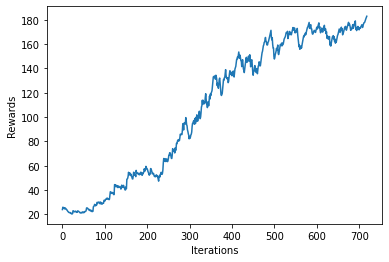

25


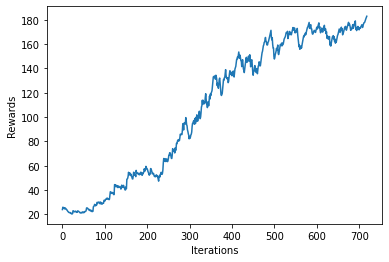

In [112]:
reinforce_reward, trained_reinforce_model = run_episodes(
    create_reinforce_model, reinforce_policy, train_reinforce, 2000, False, False)
trained_reinforce_model.save('trained_reinforce_model.h5')


In [113]:

def avg_plotter(rew, time_step):
    '''
    Function to plot average learning profile
    
            Parameters:
                    rew (array): The episodic rewards
                    time_step (int): The number of episodes to average over
     '''
    rew = rew[0, rew[0, :] != 0]
    avg = []
    for x in range(int(len(rew[:])/time_step)-1):
        avg.append(np.mean(rew[x*time_step:(x+1)*time_step]))
    plt.plot(avg)


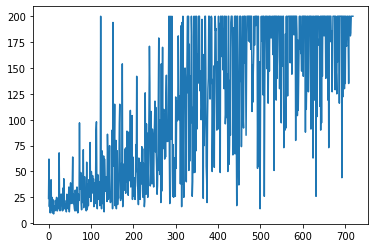

In [114]:

avg_plotter(reinforce_reward, 1)


## DQN


In [115]:
def create_DQN():
    '''
    Function to create DQN model
            Returns:
                    The DQN neural network
     '''
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(24, input_shape=[4], activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(2)])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
    return model


In [116]:
class ReplayBuffer():
    current_index = 0

    def __init__(self, size=10000):
        self.size = size
        self.transitions = []

    def add(self, transition):
        if len(self.transitions) < self.size:
            self.transitions.append(transition)
        else:
            self.transitions[self.current_index] = transition
            self.__increment_current_index()

    def length(self):
        return len(self.transitions)

    def get_batch(self, batch_size):
        return random.sample(self.transitions, batch_size)

    def __increment_current_index(self):
        self.current_index += 1
        if self.current_index >= self.size - 1:
            self.current_index = 0


In [117]:
def eps_greedy(model, state, epsilon):
    '''
    Function to chose an action given a state following the epsilon greedy polcicy    
            Parameters:
                    model (tensorflow model): The tensorflow model giving the state action values
                    state (array): The current state of the agent
                    epsilon (float): The probability of chosing action with worse state action value
            Returns:
                    The action taken by the agent
     '''

    val = np.random.uniform(0, 1)
    if val < epsilon:
        return np.random.randint(0, 2)
    else:
        q_vals = model.predict(np.array([state]))
        return np.argmax(q_vals[0])


In [118]:
def copy_model(model, target_model):
    '''
    Function to copy base model and create new target model
    
            Parameters:
                    model (tensorflow model): The base model of the DDQN
                    target_model (tensorflow model): The target model of the DDQN
            Returns:
                    The new target model
     '''
    target_model.set_weights(model.get_weights())
    return target_model


In [119]:
def train_DQN(model, transitions, target_model, dual):
    '''
    Function to train base model
    
            Parameters:
                    model (tensorflow model): The base DQN model
                    transitions (array): The transition tuples 
                    target_model (tensorflow model): The target model of the DDQN
                    dual (binary): 0 for using DQN, 1 for using DDQN
            Returns:
                    None
     '''
    
    gamma = 0.95
    states = np.zeros([len(transitions), len(transitions[0][0])])
    new_states = np.zeros([len(transitions), len(transitions[0][0])])
    rewards = np.zeros([1, len(transitions)])
    dones = np.zeros([1, len(transitions)])
    actions = np.zeros([len(transitions), 2], dtype='int')

    for i, (old_state, action, reward, done, new_state) in enumerate(transitions):
        new_states[i, :] = new_state
        rewards[0, i] = reward
        dones[0, i] = done
        states[i, :] = old_state
        actions[i, :] = i, action
    qmaxes = model.predict(new_states)
    full_q = model.predict(states)

    if not dual:
        q_targets = rewards[0, :]+gamma*np.max(qmaxes, axis=1)*(1-dones[0, :])
    else:
        qmax = target_model.predict(new_states)
        choices = np.array([[i, np.argmax(row)]
                           for i, row in enumerate(full_q)])
        q_targets = rewards[0, :]+gamma * \
            qmax[tuple(np.transpose(choices))]*(1-dones[0, :])

    full_q[tuple(np.transpose(actions))] = q_targets

    model.fit([states], [full_q], verbose=0)


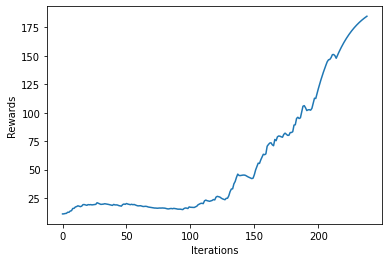

25


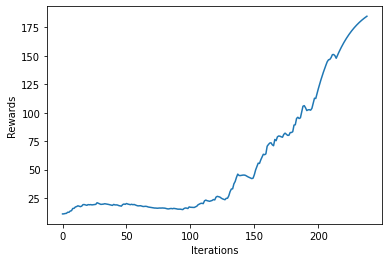

In [120]:
DQN_reward, trained_DQN_model = run_episodes(
    create_DQN, eps_greedy, train_DQN, 2000, True, False)
trained_DQN_model.save('trained_DQN_model.h5')


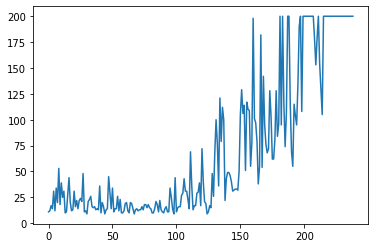

In [121]:
avg_plotter(DQN_reward, 1)


## DDQN

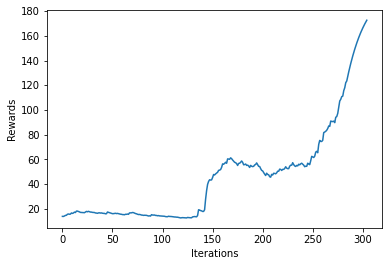

25


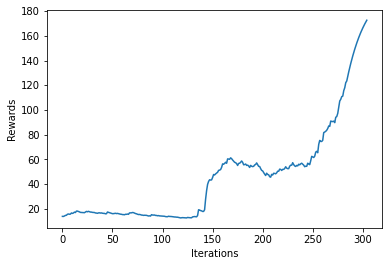

In [122]:
DQN_reward2, trained_dual_DQN_model = run_episodes(
    create_DQN, eps_greedy, train_DQN, 2000, True, True)
trained_dual_DQN_model.save('trained_dual_DQN_model.h5')


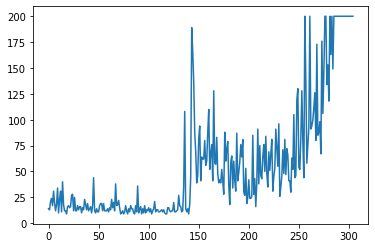

In [123]:
avg_plotter(DQN_reward2, 1)


# Combined Learning Profiles

## Unsmoothed learning profiles

720
240
306


Text(0.5, 0, 'Episodes Experienced')

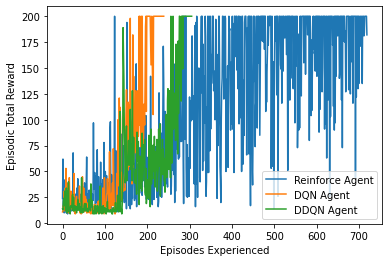

In [190]:
labels = ['Reinforce Agent', 'DQN Agent', 'DDQN Agent']
for i, rewards in enumerate([reinforce_reward, DQN_reward, DQN_reward2, ]):
    rewards = rewards[0, rewards[0, :] != 0]
    print(len(rewards)) # Shows when agent solved environment
    plt.plot(rewards, label=labels[i])
plt.legend()
plt.ylabel('Episodic Total Reward')
plt.xlabel('Episodes Experienced')


## Smoothed learning profiles

Text(0.5, 0, 'Episodes Experienced')

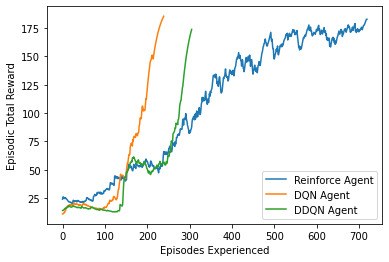

In [186]:
labels = ['Reinforce Agent', 'DQN Agent', 'DDQN Agent']
for i, rewards in enumerate([reinforce_reward, DQN_reward, DQN_reward2, ]):
    store = mdl.util.LossHistory(smoothing_factor=0.95)
    for rew in rewards[0, rewards[0, :] != 0]:
        store.append(rew)
    smoothed = store.get()
    plt.plot(smoothed, label=labels[i])
plt.legend()
plt.ylabel('Episodic Total Reward')
plt.xlabel('Episodes Experienced')


## Experiments

In [124]:
def run_experiments(model, noise_var, iterations, DQN):
    '''
    Function to create cartpole environment with added noise
    
            Parameters:
                    model (tensorflow model): The model being experimented on
                    noise_var (float): The variance of the added gaussian noise
                    iterations (int): The number of iterations of the experiment
                    DQN (binary): 1 for using DQN or DDQN and 0 otherwise
            Returns:
                    The average reward and variance of the rewards
     '''
    env = gym.make("CartPole-v1")
    total_reward = np.zeros([1, iterations])
    for it in range(iterations):
        observation = env.reset()
        ep_rewards = []
        done = False
        t = 0
        while not done:
            if DQN:
                action = np.argmax(model.predict(np.array([observation]))[0])
            else:
                action = np.random.choice(
                    [0, 1], p=model.predict(np.array([observation]))[0])
            observation, reward, done, info = env.step(action)
            observation = add_noise(observation, noise_var)
            ep_rewards.append(reward)
            t += 1
            if t >= 200:
                break
        total_reward[0, it] = np.sum(ep_rewards)
    return np.mean(total_reward[0, :]), np.var(total_reward[0, :])


In [125]:
def add_noise(observation, noise_var):
    '''
    Function to add gaussian noise
    
            Parameters:
                    observation (array): The state of the agent
                    noise_var (float): The variance of the added gaussian noise
            Returns:
                    The state of the agent with the added noise
     '''
    return observation+np.random.normal(0, noise_var, len(observation))


In [126]:

noise_vars = np.linspace(0, 1, 11) #array of noise variances
models = [tf.keras.models.load_model('trained_reinforce_model.h5'), tf.keras.models.load_model(
    'trained_DQN_model.h5'), tf.keras.models.load_model('trained_dual_DQN_model.h5')] #array of models
reward = np.zeros([len(noise_vars), len(models)])
variance = np.zeros([len(noise_vars), len(models)])
n = 100
for i, var in enumerate(noise_vars):#run all variances
    print(i)
    for j, model in enumerate(models): #run all models
        DQN = j > 0
        reward[i, j], variance[i, j] = run_experiments(model, var, n, DQN) #run experiments


0
1
2
3
4
5
6
7
8
9
10


# Model plots 


## Percent Decrease in Performance

Text(0, 0.5, 'Percent Change in Total Reward (%)')

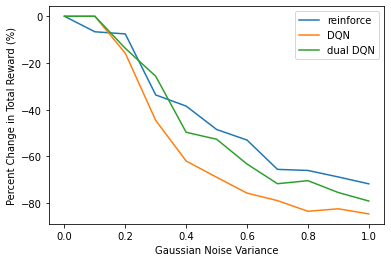

In [127]:
reinforce_noise_reward = (reward[:, 0]-reward[0, 0])/reward[0, 0]
DQN_noise_reward = (reward[:, 1]-reward[0, 1])/reward[0, 1]
dual_DQN_noise_reward = (reward[:, 2]-reward[0, 2])/reward[0, 2]
plt.plot(noise_vars, reinforce_noise_reward*100, label='reinforce')
plt.plot(noise_vars, DQN_noise_reward*100, label='DQN')
plt.plot(noise_vars, dual_DQN_noise_reward*100, label='dual DQN')
plt.legend()
plt.xlabel('Gaussian Noise Variance')
plt.ylabel('Percent Change in Total Reward (%)')


In [130]:
lower_bounds = np.zeros([len(variance[:, 0]), 3])
upper_bounds = np.zeros([len(variance[:, 0]), 3])
for i in range(3):
    per_chang = (reward[:, i]-reward[0, i])/reward[0, i]*100
    se = abs(reward[:, i]/reward[0, i])*(variance[:, i]/n /
                                         (reward[:, i]**2)+variance[0, i]/n/(reward[0, i]**2))**(1/2)*100
    lower_bounds[:, i] = -1.65*se
    upper_bounds[:, i] = 1.65*se


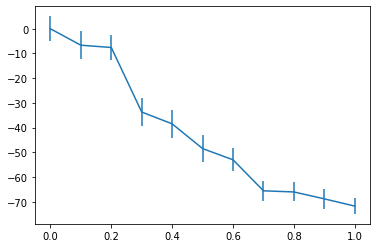

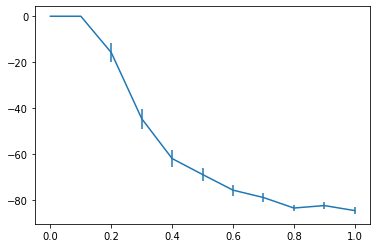

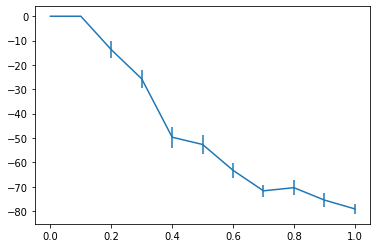

In [134]:
for i in range(3):
    errors = np.array(np.concatenate(
        [[lower_bounds[:, i]], [upper_bounds[:, i]]], axis=0))
    rew = (reward[:, i]-reward[0, i])/reward[0, i]*100
    plt.figure()
    plt.errorbar(noise_vars, rew, yerr=np.abs(errors))


Text(0, 0.5, 'Percent Change in Total Reward (%)')

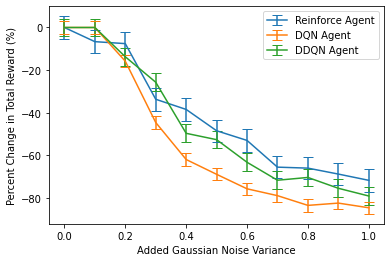

In [193]:
labels = ['Reinforce Agent', 'DQN Agent', 'DDQN Agent']
for i in range(3):
    errors = np.array(np.concatenate(
        [[lower_bounds[:, i]], [upper_bounds[:, i]]], axis=0))
    rew = (reward[:, i]-reward[0, i])/reward[0, i]*100
    plt.errorbar(noise_vars, rew, yerr=np.abs(
        errors), label=labels[i], capsize=5)
plt.legend()
plt.xlabel('Added Gaussian Noise Variance')
plt.ylabel('Percent Change in Total Reward (%)')


## Episodic Return

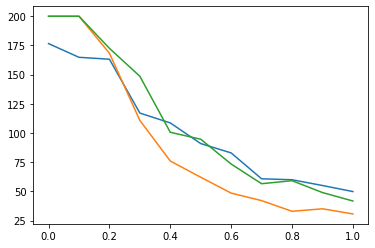

In [138]:
plt.plot(noise_vars, reward)


In [200]:
lower_bounds = np.zeros([len(variance[:, 0]), 3])
upper_bounds = np.zeros([len(variance[:, 0]), 3])
talpha = t.ppf(0.025, 99)
for i in range(3):
    for j in range(len(noise_vars)):
        se = (variance[j, i]/n)**0.5
        lower_bounds[j, i] = talpha*se
        upper_bounds[j, i] = -talpha*se


Text(0.5, 0, 'Added Gauisan Noise Variance')

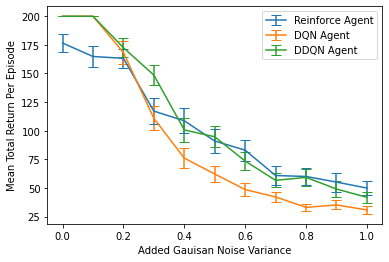

In [202]:
labels = ['Reinforce Agent', 'DQN Agent', 'DDQN Agent']
for i in range(3):
    errors = np.array(np.concatenate(
        [[lower_bounds[:, i]], [upper_bounds[:, i]]], axis=0))
    rew = reward[:, i]
    plt.errorbar(noise_vars, rew, yerr=np.abs(
        errors), label=labels[i], capsize=5)
plt.legend()
plt.ylabel('Mean Total Return Per Episode')
plt.xlabel('Added Gauisan Noise Variance')


# Hypothesis tests

## Hypothesis test 1 P-Values

[[5.73457937e-02            nan            nan]
 [7.99272916e-01 1.60252522e-09 2.55555133e-10]
 [7.12783166e-10 2.47801779e-13 1.10551849e-04]
 [2.87722942e-01 1.03640108e-06 5.85866911e-11]
 [2.33500987e-02 1.20408869e-02 4.01453774e-01]
 [2.63834309e-01 2.67237424e-03 5.55944852e-04]
 [4.16270530e-04 8.10523404e-02 6.95917266e-04]
 [8.85946357e-01 9.07559398e-04 5.97234313e-01]
 [3.88876083e-01 4.12784883e-01 4.97324446e-02]
 [3.24625179e-01 1.01926823e-01 9.08581391e-02]]


C:\Users\Thomas\AppData\Local\Temp/ipykernel_21120/4030087638.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tval=(reward[j,i]-reward[j-1,i])/((sp2*(1/n+1/n))**(1/2))


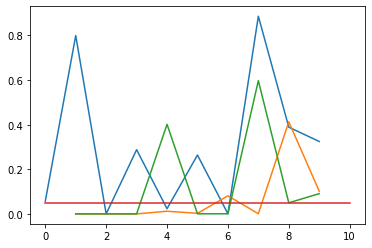

In [209]:

pvals = np.zeros([len(variance[1:, 0]), 3])
for i in range(3):
    for j in range(1, len(noise_vars)):
        sp2 = ((n-1)*variance[j, i]+(n-1)*variance[j-1, i])/(2*n-2)
        tval = (reward[j, i]-reward[j-1, i])/((sp2*(1/n+1/n))**(1/2))
        pvals[j-1, i] = 2*(1-t.cdf(np.abs(tval), 2*n-2))
print(pvals)
plt.plot(np.arange(10), pvals)
plt.plot([0, 10], [0.05, 0.05])
np.savetxt('table_seq.csv', pvals, fmt='%s', delimiter=',')


## Hypothesis test 2 P-Values

In [214]:

pvals = np.zeros([len(variance[1:, 0])-1, 3])
for i in range(3):
    for j in range(2, len(noise_vars)):
        sp2 = ((n-1)*variance[j, i]+(n-1)*variance[j-2, i])/(2*n-2)
        tval = (reward[j, i]-reward[j-2, i])/((sp2*(1/n+1/n))**(1/2))
        pvals[j-2, i] = 2*(1-t.cdf(np.abs(tval), 2*n-2))
print(pvals)
np.savetxt('table_seq2.csv', pvals, fmt='%s', delimiter=',')


[[2.03811428e-02 1.60252522e-09 2.55555133e-10]
 [1.10190101e-09 0.00000000e+00 0.00000000e+00]
 [2.19602114e-13 0.00000000e+00 0.00000000e+00]
 [1.13044109e-03 5.91082738e-13 1.35447209e-14]
 [4.30822537e-04 4.47954238e-07 4.62873274e-05]
 [1.55424710e-05 1.02265102e-06 1.36263223e-10]
 [1.98468841e-04 8.46313318e-06 8.99227425e-03]
 [3.26026966e-01 1.82699324e-02 1.02378085e-01]
 [4.61976421e-02 3.54055744e-01 1.93839416e-04]]


## Hypothesis test 3 P-Values

In [216]:

comp_pvals = np.zeros([3, len(variance[:, 0]), 3])
iss = np.array([0, 1, 2])
for i in iss:
    for j in range(len(noise_vars)):
        for k in iss[iss != i]:
            sp2 = ((n-1)*variance[j, i]+(n-1)*variance[j, k])/(2*n-2)
            tval = (reward[j, i]-reward[j, k])/((sp2*(1/n+1/n))**(1/2))
            comp_pvals[i, j, k] = 2*(1-t.cdf(np.abs(tval), 2*n-2))
print(comp_pvals)
np.savetxt('table_seq3.csv', comp_pvals[0, :, :], fmt='%s', delimiter=',')
np.savetxt('table_seq4.csv', comp_pvals[2, :, :], fmt='%s', delimiter=',')


[[[0.00000000e+00 5.32602007e-09 5.32602007e-09]
  [0.00000000e+00 5.65414382e-12 5.65414382e-12]
  [0.00000000e+00 4.34938505e-01 1.16596420e-01]
  [0.00000000e+00 4.22776638e-01 2.18095312e-05]
  [0.00000000e+00 5.70913186e-06 2.94746639e-01]
  [0.00000000e+00 1.12502717e-05 6.08069225e-01]
  [0.00000000e+00 2.44727238e-09 1.14227146e-01]
  [0.00000000e+00 7.10964746e-05 4.10373566e-01]
  [0.00000000e+00 1.25644206e-09 8.83833050e-01]
  [0.00000000e+00 2.57578670e-05 2.65225724e-01]
  [0.00000000e+00 3.93665202e-07 4.81611444e-02]]

 [[5.32602007e-09 0.00000000e+00            nan]
  [5.65414382e-12 0.00000000e+00            nan]
  [4.34938505e-01 0.00000000e+00 5.18654063e-01]
  [4.22776638e-01 0.00000000e+00 1.63300734e-07]
  [5.70913186e-06 0.00000000e+00 4.19887945e-04]
  [1.12502717e-05 0.00000000e+00 5.83222628e-08]
  [2.44727238e-09 0.00000000e+00 6.06811572e-07]
  [7.10964746e-05 0.00000000e+00 1.51475367e-04]
  [1.25644206e-09 0.00000000e+00 2.13770068e-09]
  [2.57578670e-05 

C:\Users\Thomas\AppData\Local\Temp/ipykernel_21120/4230490197.py:8: RuntimeWarning: invalid value encountered in double_scalars
  tval=(reward[j,i]-reward[j,k])/((sp2*(1/n+1/n))**(1/2))
